In [1]:
#Import dependencies.
import pandas as pd
from sqlalchemy import create_engine

#Import raw data tables in sqlite file as pandas dataframes.
database_path = 'storage.sqlite'

engine = create_engine(f'sqlite:///{database_path}')
con = engine.connect()

df = pd.read_sql('SELECT * FROM gamedata', con)
df_pick = pd.read_sql('SELECT * FROM picks', con)
df_red = pd.read_sql('SELECT * FROM redBans', con)
df_blue = pd.read_sql('SELECT * FROM blueBans', con)

con.close()

#Import toxic score from csv.
df_toxic_score = pd.read_csv('toxic_score.csv')

#Create a dataframe of in-game stats by player and position.

#Change summonerName to IRL name.
df['summonerName'] = df['summonerName'].replace({
    'The Life of Andy': 'Andy',
    'Fer Sharks': 'Jackson',
    'Diet Smite': 'Kori',
    'Santa kums 2nite': 'Kori',
    'B1ng Chillin': 'Kori',
    'Brony Hole': 'Luke',
    'cloaca buss down': 'Rob',
    'glocktobussy': 'Tonnie',
    'BeaIs': 'Beals',
    'Large Ski11 Gap': 'Tyler',
    'Net n Yahoo': 'Tyler',
    'Sp4nK1n M0nK3y5': 'Tyler',
    'SmokeDopeNotCope': 'Tyler',
    'HTXpanda': 'Jess',
    'NickBlumer': 'Nick B.',
    'G4ytr0x': 'Moo',
    'M4SHALLAH': 'Moo',
    'the scouts chode': 'Moo',
    'For Gun': 'Moo',
    'ezcyabye': 'Moo',
    'Anonymous Lemur': 'Nick D.',
    'Despp': 'Desp',
    'ducks on pond': 'Anthony',
    'Kinga': 'Kinga',
    'YoungOcelot': 'Milroy',
    'ScottSucks':'Furb',
    'SprightReamicks': 'Franklin'
})

#Manually edit incorrect role assignment.
df.loc[df['summonerName'] == 'Jess', 'individualPosition'] = 'UTILITY'
df.loc[df['championName'] == 'Twitch', 'individualPosition'] = 'BOTTOM'
df.loc[df['championName'] == 'Nautilus', 'individualPosition'] = 'UTILITY'

#Add toxic score by role.
df_top = df.loc[df['individualPosition'] == 'TOP']
df_top_TS = df_toxic_score.loc[df_toxic_score['position'] == 'TOP']
top_TS_list = df_top_TS['toxic_score'].tolist()
df_top['toxic_score'] = top_TS_list

df_jung = df.loc[df['individualPosition'] == 'JUNGLE']
df_jung_TS = df_toxic_score.loc[df_toxic_score['position'] == 'JUNGLE']
jung_TS_list = df_jung_TS['toxic_score'].tolist()
df_jung['toxic_score'] = jung_TS_list

df_mid = df.loc[df['individualPosition'] == 'MIDDLE']
df_mid_TS = df_toxic_score.loc[df_toxic_score['position'] == 'MIDDLE']
mid_TS_list = df_mid_TS['toxic_score'].tolist()
df_mid['toxic_score'] = mid_TS_list

df_bot = df.loc[df['individualPosition'] == 'BOTTOM']
df_bot_TS = df_toxic_score.loc[df_toxic_score['position'] == 'BOTTOM']
bot_TS_list = df_bot_TS['toxic_score'].tolist()
df_bot['toxic_score'] = bot_TS_list

df_supp = df.loc[df['individualPosition'] == 'UTILITY']
df_supp_TS = df_toxic_score.loc[df_toxic_score['position'] == 'UTILITY']
supp_TS_list = df_supp_TS['toxic_score'].tolist()
df_supp['toxic_score'] = supp_TS_list

df = pd.concat([df_top, df_jung, df_mid, df_bot, df_supp])

#Add MVP (highest toxic score on winning team) and ACE (highest toxic score on losing team)
win_df = df.loc[df['win'] == '1']
win_list = win_df['toxic_score'].tolist()
win_list2 = []
win_list3 = []

for i in range(0, int(len(win_list)/5)):
    win_list2.append(win_list[i*5:(i+1)*5])
    
for i in range(len(win_list2)):
    highest_score = max(win_list2[i])
    for j in range(0, 5):
        if highest_score == win_list2[i][j]:
            win_list2[i][j] = 1
        else:
            win_list2[i][j] = 0

for i in range(len(win_list2)):
    for j in range(0, 5):
        win_list3.append(win_list2[i][j])

win_df['MVP'] = win_list3
win_df['ACE'] = 0

loss_df = df.loc[df['win'] == '0']
loss_list = loss_df['toxic_score'].tolist()
loss_list2 = []
loss_list3 = []

for i in range(0, int(len(loss_list)/5)):
    loss_list2.append(loss_list[i*5:(i+1)*5])
    
for i in range(len(loss_list2)):
    highest_score = max(loss_list2[i])
    for j in range(0, 5):
        if highest_score == loss_list2[i][j]:
            loss_list2[i][j] = 1
        else:
            loss_list2[i][j] = 0

for i in range(len(loss_list2)):
    for j in range(0, 5):
        loss_list3.append(loss_list2[i][j])

loss_df['MVP'] = 0
loss_df['ACE'] = loss_list3

df = pd.concat([win_df, loss_df]).sort_values(by = 'gameId')

#Edit/add columns.
df['gameDuration'] = df['gameDuration']/60
df['cs'] = df['totalMinionsKilled'] + df['neutralMinionsKilled']
df['teamId'] = df['teamId'].replace(100, 'BLUE')
df['teamId'] = df['teamId'].replace(200, 'RED')
change_col_list = ['win', 'firstBloodKill', 'firstBloodAssist', 'firstTowerKill', 'firstTowerAssist']
for i in change_col_list:
    df[i] = df[i].replace('1', 1)
    df[i] = df[i].replace('0', 0)

#Calculate total team damage dealt, total team damage taken, and total team kills for each side in each game. Merge data into existing dataframe and rename.
df_total_team_gold = df.groupby(['gameId', 'teamId'])['goldEarned'].sum()
df1 = pd.merge(df, df_total_team_gold, on = ['gameId', 'teamId'])

df_total_team_dmg = df.groupby(['gameId', 'teamId'])['totalDamageDealtToChampions'].sum()
df2 = pd.merge(df1, df_total_team_dmg, on = ['gameId', 'teamId'])

df_total_team_dmg_tkn = df.groupby(['gameId', 'teamId'])['totalDamageTaken'].sum()
df3 = pd.merge(df2, df_total_team_dmg_tkn, on = ['gameId', 'teamId'])

df_total_team_kills = df.groupby(['gameId', 'teamId'])['kills'].sum()
df4 = pd.merge(df3, df_total_team_kills, on = ['gameId', 'teamId'])

df_total_player_games = df.groupby(['summonerName'])['gameId'].nunique()
df4 = pd.merge(df4, df_total_player_games, on = ['summonerName'])

df_total_champ_games = df.groupby(['championName'])['gameId'].nunique()
df4 = pd.merge(df4, df_total_champ_games, on = ['championName'])

df4 = df4.rename(columns = {
    'goldEarned_x': 'goldEarned',
    'goldEarned_y': 'team_goldEarned',
    'totalDamageDealtToChampions_x': 'totalDamageDealtToChampions',
    'totalDamageDealtToChampions_y': 'team_totalDamageDealtToChampions',
    'totalDamageTaken_x': 'totalDamageTaken',
    'totalDamageTaken_y': 'team_totalDamageTaken',
    'kills_x': 'kills',
    'kills_y': 'team_kills',
    'gameId_x': 'gameId',
    'gameId_y': 'total_player_games',
    'gameId': 'total_champ_games'
})

#Create dataframe grouped by Position and Name showing games played, wins, losses, and win percent.
df5 = df4[['individualPosition', 'summonerName', 'gameId']].groupby(['individualPosition', 'summonerName']).nunique()
df6 = df4[['individualPosition', 'summonerName', 'win']].groupby(['individualPosition', 'summonerName']).sum()

df7 = pd.merge(df5, df6, on=['individualPosition', 'summonerName'])
df7['loss'] = df7['gameId'] - df7['win']
df7['wp'] = df7['win'] / df7['gameId']

#Create dataframe grouped by Position and Name showing appropriate stats to track per min.
df_per_min = df4[['summonerName', 'individualPosition', 'gameDuration', 'cs', 'goldEarned', 'totalDamageDealtToChampions', 'totalDamageTaken', 'totalHeal', 'totalHealsOnTeammates', 
                  'totalDamageShieldedOnTeammates', 'visionScore', 'wardsPlaced', 'wardsKilled']]
df_per_min = df_per_min.groupby(['individualPosition', 'summonerName']).sum()

df_per_min['cspm'] = df_per_min['cs'] / df_per_min['gameDuration']
df_per_min['gpm'] = df_per_min['goldEarned'] / df_per_min['gameDuration']
df_per_min['dpm'] = df_per_min['totalDamageDealtToChampions'] / df_per_min['gameDuration']
df_per_min['dtpm'] = df_per_min['totalDamageTaken'] / df_per_min['gameDuration']
df_per_min['hpm'] = df_per_min['totalHeal'] / df_per_min['gameDuration']
df_per_min['ahspm'] = (df_per_min['totalHealsOnTeammates'] + df_per_min['totalDamageShieldedOnTeammates']) / df_per_min['gameDuration']
df_per_min['vspm'] = df_per_min['visionScore'] / df_per_min['gameDuration']
df_per_min['wppm'] = df_per_min['wardsPlaced'] / df_per_min['gameDuration']
df_per_min['wkpm'] = df_per_min['wardsKilled'] / df_per_min['gameDuration']
df_per_min['dpg'] = df_per_min['dpm'] / df_per_min['gpm']

df_per_min = df_per_min[['cspm', 'gpm', 'dpm', 'dtpm', 'hpm', 'ahspm', 'vspm', 'wppm', 'wkpm', 'dpg']]

#Create dataframe with appropriate per game stats and grouped by Position and Name.
df8 = df4[['individualPosition', 'summonerName', 'kills', 'deaths', 'assists', 'goldEarned', 'totalDamageDealtToChampions', 'totalDamageTaken', 'timeCCingOthers', 'damageDealtToTurrets', 'firstBloodKill',
           'firstBloodAssist', 'firstTowerKill', 'firstTowerAssist', 'turretPlatesTaken', 'soloKills', 'outnumberedKills', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills', 'epicMonsterSteals',
           'skillshotsHit', 'skillshotsDodged', 'abilityUses', 'wardsGuarded', 'visionWardsBoughtInGame', 'laneMinionsFirst10Minutes', 'jungleCsBefore10Minutes', 'team_goldEarned', 
           'dragonTakedowns', 'riftHeraldTakedowns', 'team_totalDamageDealtToChampions', 'team_totalDamageTaken', 'team_kills', 'toxic_score', 'MVP', 'ACE']]
df9 = df8.groupby(['individualPosition', 'summonerName']).sum()

df9['kda'] = (df9['kills'] + df9['assists']) / (df9['deaths'])
df9['kp'] = (df9['kills'] + df9['assists']) / (df9['team_kills'])
df9['gold_perc'] = df9['goldEarned'] / df9['team_goldEarned']
df9['dmg_perc'] = df9['totalDamageDealtToChampions'] / df9['team_totalDamageDealtToChampions']
df9['dmg_tkn_perc'] = df9['totalDamageTaken'] / df9['team_totalDamageTaken']

#Merge dataframes. Note: Need number of games from first dataframe before calculating per game stats.
df10 = pd.merge(df7, df_per_min, on = ['individualPosition', 'summonerName'])
df11 = pd.merge(df10, df9, on = ['individualPosition', 'summonerName'])

#Create columns in dataframe with appropriate per game stats.
df11['kills_per_game'] = df11['kills'] / df11['gameId']
df11['deaths_per_game'] = df11['deaths'] / df11['gameId']
df11['assists_per_game'] = df11['assists'] / df11['gameId']
df11['turret_plates_taken_per_game'] = df11['turretPlatesTaken'] / df11['gameId']
df11['solo_kills_per_game'] = df11['soloKills'] / df11['gameId']
df11['outnumbered_kills_per_game'] = df11['outnumberedKills'] / df11['gameId']
df11['first_blood_involved_per_game'] = (df11['firstBloodKill'] + df11['firstBloodAssist']) / df11['gameId']
df11['first_tower_involved_per_game'] = (df11['firstTowerKill'] + df11['firstTowerAssist']) / df11['gameId']
df11['visionWardsBoughtInGame_per_game'] = df11['visionWardsBoughtInGame'] / df11['gameId']
df11['wardsGuarded_per_game'] = df11['wardsGuarded'] / df11['gameId']
df11['dragonTakedowns_per_game'] = df11['dragonTakedowns'] / df11['gameId']
df11['riftHeraldTakedowns_per_game'] = df11['riftHeraldTakedowns'] / df11['gameId']
df11['doubleKills_per_game'] = df11['doubleKills'] / df11['gameId']
df11['tripleKills_per_game'] = df11['tripleKills'] / df11['gameId']
df11['quadraKills_per_game'] = df11['quadraKills'] / df11['gameId']
df11['pentaKills_per_game'] = df11['pentaKills'] / df11['gameId']
df11['skillshotsHit_per_game'] = df11['skillshotsHit'] / df11['gameId']
df11['skillshotsDodged_per_game'] = df11['skillshotsDodged'] / df11['gameId']
df11['abilityUses_per_game'] = df11['abilityUses'] / df11['gameId']
df11['minionsFirst10Minutes_per_game'] = (df11['laneMinionsFirst10Minutes'] + df11['jungleCsBefore10Minutes']) / df11['gameId']
df11['damageDealtToTurrets_per_game'] = df11['damageDealtToTurrets'] / df11['gameId']
df11['timeCCingOthers_per_game'] = df11['timeCCingOthers'] / df11['gameId']
df11['avg_toxic_score'] = df11['toxic_score'] / df11['gameId']
df11 = df11.reset_index()

#Organize dataframe columns in desired order.
game_data = df11[['summonerName', 'individualPosition', 'gameId', 'win', 'loss', 'wp', 'kills_per_game', 'deaths_per_game', 'assists_per_game', 'kda', 'kp', 'cspm', 'gpm', 'gold_perc', 'dpm', 'dmg_perc',
                  'dpg', 'dtpm', 'dmg_tkn_perc', 'hpm', 'ahspm', 'vspm', 'wppm', 'wkpm', 'visionWardsBoughtInGame_per_game', 'wardsGuarded_per_game', 'first_blood_involved_per_game', 
                  'first_tower_involved_per_game', 'solo_kills_per_game', 'outnumbered_kills_per_game', 'doubleKills_per_game', 'tripleKills_per_game', 'quadraKills_per_game', 'pentaKills_per_game',
                  'turret_plates_taken_per_game', 'damageDealtToTurrets_per_game', 'minionsFirst10Minutes_per_game', 'timeCCingOthers_per_game', 'skillshotsHit_per_game', 'skillshotsDodged_per_game',
                  'abilityUses_per_game', 'epicMonsterSteals', 'dragonTakedowns_per_game', 'riftHeraldTakedowns_per_game', 'MVP', 'ACE', 'avg_toxic_score']]

#Create dataframe of winrate stats by player.
#Calculate wins and games played by player.
df4a = df4.groupby(['summonerName'])['win'].sum()
df4b = df4.groupby(['summonerName'])['gameId'].nunique()
df4c = pd.merge(df4a, df4b, on = ['summonerName'])

#Edit/add columns.
winrate = df4c[['gameId', 'win']]
winrate['loss'] = winrate['gameId'] - winrate['win']
winrate['wp'] = winrate['win'] / winrate['gameId']

#Create dataframe of pick ban stats.
#Edit/add columns.
df_pick['gameId'] = 1
df_pick['win'] = df_pick['win'].replace('1', 1)
df_pick['win'] = df_pick['win'].replace('0', 0)

df_pick_red = df_pick[df_pick['teamId'] == 200]
df_pick_red['teamId'] = 'RED'
df_pick_red = df_pick_red.groupby('championName').sum()
df_pick_red['loss'] = df_pick_red['gameId'] - df_pick_red['win']
df_pick_red['wp'] = df_pick_red['win'] / df_pick_red['gameId']

df_pick_blue = df_pick[df_pick['teamId'] == 100]
df_pick_blue['teamId'] = 'BLUE'
df_pick_blue = df_pick_blue.groupby('championName').sum()
df_pick_blue['loss'] = df_pick_blue['gameId'] - df_pick_blue['win']
df_pick_blue['wp'] = df_pick_blue['win'] / df_pick_blue['gameId']

#Merge dataframes of picks by side.
df_pick2 = pd.merge(df_pick_red, df_pick_blue, on = ['championName'], how ='outer')
df_pick2 = df_pick2.fillna(0)
df_pick2 = df_pick2.rename(columns = {
    'gameId_x': 'pick_red',
    'win_x': 'win_red',
    'loss_x': 'loss_red',
    'wp_x': 'wp_red',
    'gameId_y': 'pick_blue',
    'win_y': 'win_blue',
    'loss_y': 'loss_blue',
    'wp_y': 'wp_blue'
})

#Edit/add columns.
df_pick2['pick'] = df_pick2['pick_red'] + df_pick2['pick_blue']
df_pick2['win'] = df_pick2['win_red'] + df_pick2['win_blue']
df_pick2['loss'] = df_pick2['loss_red'] + df_pick2['loss_blue']
df_pick2['wp'] = df_pick2['win'] / df_pick2['pick']

#Create lists of first/second phase bans using list concat (no difference between first/second/third ban and fourth/fifth ban).
first_red_ban = df_red['firstBan'].to_list()
second_red_ban = df_red['secondBan'].to_list()
third_red_ban = df_red['thirdBan'].to_list()
fourth_red_ban = df_red['fourthBan'].to_list()
fifth_red_ban = df_red['fifthBan'].to_list()

first_phase_red_ban = first_red_ban + second_red_ban + third_red_ban
second_phase_red_ban = fourth_red_ban + fifth_red_ban

#Create dataframe from first/second phase bans.
df_red2 = pd.DataFrame(first_phase_red_ban, columns = ['championName'])
df_red3 = pd.DataFrame(second_phase_red_ban, columns = ['championName'])

#Add column to sum later.
df_red2['redFirstPhaseBan'] = 1
df_red3['redSecondPhaseBan'] = 1

#Concat dataframes and group by champion name.
red_ban = pd.concat([df_red2, df_red3])
red_ban = red_ban.fillna(0)
red_ban = red_ban.reset_index()
red_ban2 = red_ban.groupby(['championName']).sum()

#Same thing done for blue side bans.
first_blue_ban = df_blue['firstBan'].to_list()
second_blue_ban = df_blue['secondBan'].to_list()
third_blue_ban = df_blue['thirdBan'].to_list()
fourth_blue_ban = df_blue['fourthBan'].to_list()
fifth_blue_ban = df_blue['fifthBan'].to_list()

first_phase_blue_ban = first_blue_ban + second_blue_ban + third_blue_ban
second_phase_blue_ban = fourth_blue_ban + fifth_blue_ban

df_blue2 = pd.DataFrame(first_phase_blue_ban, columns=['championName'])
df_blue3 = pd.DataFrame(second_phase_blue_ban, columns=['championName'])

df_blue2['blueFirstPhaseBan'] = 1
df_blue3['blueSecondPhaseBan'] = 1

blue_ban = pd.concat([df_blue2, df_blue3])
blue_ban = blue_ban.fillna(0)
blue_ban = blue_ban.reset_index()
blue_ban2 = blue_ban.groupby(['championName']).sum()

#Merge red and blue bans.
df_ban = pd.merge(red_ban2, blue_ban2, on = ['championName'], how ='outer')
df_ban = df_ban.fillna(0)

#Add column.
df_ban['ban'] = df_ban['redFirstPhaseBan'] + df_ban['redSecondPhaseBan'] + df_ban['blueFirstPhaseBan'] + df_ban['blueSecondPhaseBan']

#Merge pick and ban data.
pick_ban = pd.merge(df_ban, df_pick2, on = ['championName'], how ='outer')
pick_ban = pick_ban.fillna(0)

#Add columns.
pick_ban['pickban_perc'] = (pick_ban['pick'] + pick_ban['ban']) / len(df['gameId'].unique().tolist())
pick_ban['FirstPhaseBan'] = pick_ban['redFirstPhaseBan'] + pick_ban['blueFirstPhaseBan']
pick_ban['SecondPhaseBan'] = pick_ban['redSecondPhaseBan'] + pick_ban['blueSecondPhaseBan']
pick_ban['ban_red'] = pick_ban['redFirstPhaseBan'] + pick_ban['redSecondPhaseBan']
pick_ban['ban_blue'] = pick_ban['blueFirstPhaseBan'] + pick_ban['blueSecondPhaseBan']

#Organize dataframe columns in desired order.
pick_ban = pick_ban.reset_index()
pick_ban = pick_ban[['championName', 'pickban_perc', 'pick', 'ban', 'win', 'loss', 'wp', 
                    'pick_red', 'win_red', 'loss_red', 'wp_red', 
                    'pick_blue', 'win_blue', 'loss_blue', 'wp_blue',
                    'FirstPhaseBan', 'SecondPhaseBan',
                    'ban_red', 'redFirstPhaseBan', 'redSecondPhaseBan', 'ban_blue', 'blueFirstPhaseBan', 'blueSecondPhaseBan']]

#Create grid display of Win/Loss between two players on the opposite team.
#Create list of players in alphabetical order and a dataframe with gameId, name, and result for each game each player has played.
player_list = df['summonerName'].unique().tolist()
player_list = sorted(player_list)
test = df4[['gameId', 'summonerName', 'win']]

#Function to take in two player names and output each players wins when the other player in on the opposite team.
playerA_wins = []
playerB_wins = []
def getHeadToHeadData(playerA, playerB):
    opp_team1 = test[test['summonerName'] == playerA]
    opp_team2 = test[test['summonerName'] == playerB]
    opp_team3 = pd.merge(opp_team1, opp_team2, on = 'gameId', how = 'inner')
    opp_team4 = opp_team3[opp_team3['win_x'] != opp_team3['win_y']]
    playerA_wins.append(opp_team4['win_x'].sum())
    playerB_wins.append(opp_team4['win_y'].sum())
    return

#Generate head to head data. Output is two lists of ints.
for i in range(len(player_list)):
    for j in range(len(player_list)):
        getHeadToHeadData(player_list[i], player_list[j])

#Create a list stitching the two lists together, showing 'W - L' for i row (playerA) against j column (playerB).
h2h_list = []
for i in range(len(playerA_wins)):
    h2h_list.append(f'{playerB_wins[i]} - {playerA_wins[i]}')

#Create empty dataframe grid of player names (columns and rows).
head_to_head = pd.DataFrame(index=player_list, columns=player_list).fillna(0)

#Put data in dataframe. h2h_list is indexed to be desired column data, splice list and add to column in dataframe.
for i in range(len(player_list)):
    head_to_head[player_list[i]] = h2h_list[len(player_list)*i:len(player_list)*(i+1)]

#Create grid display of Win/Loss between two players on the same team.
#Function to take in two player names and output each players wins when the other player in on the same team.
playersAB_wins = []
playersAB_losses = []
def getSameTeamData(playerA, playerB):
    same_team1 = test[test['summonerName'] == playerA]
    same_team2 = test[test['summonerName'] == playerB]
    same_team3 = pd.merge(same_team1, same_team2, on = 'gameId', how = 'inner')
    same_team4 = same_team3[same_team3['win_x'] == same_team3['win_y']]
    playersAB_wins.append(same_team4['win_x'].sum())
    playersAB_losses.append(len(same_team4.index) - same_team4['win_x'].sum())
    return

#Generate head to head data. Output is two lists of ints.
for i in range(len(player_list)):
    for j in range(len(player_list)):
        getSameTeamData(player_list[i], player_list[j])

#Create a list stitching the two lists together, showing 'W - L' for i row (playerA) with j column (playerB).
same_team_list = []
for i in range(len(playersAB_wins)):
    same_team_list.append(f'{playersAB_wins[i]} - {playersAB_losses[i]}')

#Create empty dataframe grid of player names (columns and rows).
same_team = pd.DataFrame(index=player_list, columns=player_list).fillna(0)

#Put data in dataframe. h2h_list is indexed to be desired column data, splice list and add to column in dataframe.
for i in range(len(player_list)):
    same_team[player_list[i]] = same_team_list[len(player_list)*i:len(player_list)*(i+1)]

#Edit dataframes for export to JSON file.
game_data = game_data[game_data['gameId'] > 5]
game_data = game_data.replace({'individualPosition': {'TOP': 'Top', 'JUNGLE': 'Jung', 'MIDDLE': 'Mid', 'BOTTOM': 'Bot', 'UTILITY': 'Supp'}})
game_data = game_data.rename(columns = {
    'gameId': 'NumberOfGames',
    'win': 'Wins',
    'loss': 'Losses',
    'wp': 'WinPercent',
    'kills_per_game': 'KillsPerGame',
    'deaths_per_game': 'DeathsPerGame',
    'assists_per_game': 'AssistsPerGame',
    'kda': 'KDA',
    'kp': 'KillParticipation',
    'cspm': 'CSPerMin',
    'gpm': 'GoldPerMin',
    'gold_perc': 'GoldPercent',
    'dpm': 'DamagePerMin',
    'dmg_perc': 'DamagePercent',
    'dpg': 'DamagePerGold',
    'dtpm': 'DamageTakenPerMin',
    'dmg_tkn_perc': 'DamageTakenPercent',
    'hpm': 'SelfHealingPerMin',
    'ahspm': 'AllyHealingShieldingPerMin',
    'vspm': 'VisionScorePerMin',
    'wppm': 'WardsPlacedPerMin',
    'wkpm': 'WardsKilledPerMin',
    'visionWardsBoughtInGame_per_game': 'PinksBoughtPerGame',
    'wardsGuarded_per_game': 'WardsGuardedPerGame', 
    'first_blood_involved_per_game': 'FirstBloodPercent',
    'first_tower_involved_per_game': 'FirstTowerPercent',
    'solo_kills_per_game': 'SoloKillsPerGame',
    'outnumbered_kills_per_game': 'OutnumberedKillsPerGame',
    'doubleKills_per_game': 'DoubleKillsPerGame',
    'tripleKills_per_game': 'TripleKillsPerGame',
    'quadraKills_per_game': 'QuadraKillsPerGame',
    'pentaKills_per_game': 'PentaKillsPerGame',
    'turret_plates_taken_per_game': 'TurretPlatesTakenPerGame',
    'damageDealtToTurrets_per_game': 'DamageToTurretsPerGame',
    'minionsFirst10Minutes_per_game': 'CSat10MinPerGame',
    'timeCCingOthers_per_game': 'TimeCCingOthersPerGame',
    'skillshotsHit_per_game': 'SkillshotsHitPerGame',
    'skillshotsDodged_per_game': 'SkillshotsDodgedPerGame',
    'abilityUses_per_game': 'AbilityUsesPerGame',
    'epicMonsterSteals': 'EpicMonsterSteals',
    'dragonTakedowns_per_game': 'DragonsPerGame',
    'riftHeraldTakedowns_per_game': 'HeraldsPerGame',
    'MVP': 'MVP',
    'ACE': 'ACE',
    'avg_toxic_score': 'AvgToxicScore'
})
game_data['WinPercent'] = game_data['WinPercent']*100
game_data['KillParticipation'] = game_data['KillParticipation']*100
game_data['GoldPercent'] = game_data['GoldPercent']*100
game_data['DamagePercent'] = game_data['DamagePercent']*100
game_data['DamageTakenPercent'] = game_data['DamageTakenPercent']*100
game_data['FirstBloodPercent'] = game_data['FirstBloodPercent']*100
game_data['FirstTowerPercent'] = game_data['FirstTowerPercent']*100

winrate['wp'] = winrate['wp']*100
winrate = winrate.reset_index(drop = False)

pick_ban = pick_ban[pick_ban['pickban_perc'] > 0.1499]
pick_ban = pick_ban.rename(columns = {
    'pickban_perc': 'PickBanPercent',
    'pick': 'Picks',
    'ban': 'Bans',
    'win': 'Wins',
    'loss': 'Losses',
    'wp': 'WinPercent',
    'pick_red': 'RedPicks',
    'win_red': 'RedWins',
    'loss_red': 'RedLosses',
    'wp_red': 'RedWinPercent',
    'pick_blue': 'BluePicks',
    'win_blue': 'BlueWins',
    'loss_blue': 'BlueLosses',
    'wp_blue': 'BlueWinPercent',
    'FirstPhaseBan': 'FirstPhaseBan',
    'SecondPhaseBan': 'SecondPhaseBan',
    'ban_red': 'RedBans',
    'redFirstPhaseBan': 'RedFirstPhaseBan',
    'redSecondPhaseBan': 'RedSecondPhaseBan',
    'ban_blue': 'BlueBans',
    'blueFirstPhaseBan': 'BlueFirstPhaseBan',
    'blueSecondPhaseBan': 'BlueSecondPhaseBan'
})
pick_ban['PickBanPercent'] = pick_ban['PickBanPercent']*100
pick_ban['WinPercent'] = pick_ban['WinPercent']*100
pick_ban['RedWinPercent'] = pick_ban['RedWinPercent']*100
pick_ban['BlueWinPercent'] = pick_ban['BlueWinPercent']*100
pick_ban = pick_ban.sort_values(by = 'championName')

df4 = df4.replace({'teamId': {'BLUE': 'Blue', 'RED': 'Red'}})
df4 = df4.replace({'win': {1: 'Win', 0: 'Loss'}})
df4 = df4.replace({'individualPosition': {'TOP': 'Top', 'JUNGLE': 'Jung', 'MIDDLE': 'Mid', 'BOTTOM': 'Bot', 'UTILITY': 'Supp'}})

df4['KillParticipation'] = (df4['kills'] + df4['assists']) / df4['team_kills']
df4['GoldPercent'] = df4['goldEarned'] / df4['team_goldEarned']
df4['DamageDealtPercent'] = df4['totalDamageDealtToChampions'] / df4['team_totalDamageDealtToChampions']
df4['DamageTakenPercent'] = df4['totalDamageTaken'] / df4['team_totalDamageTaken']

df4['KillParticipation'] = df4['KillParticipation']*100
df4['GoldPercent'] = df4['GoldPercent']*100
df4['DamageDealtPercent'] = df4['DamageDealtPercent']*100
df4['DamageTakenPercent'] = df4['DamageTakenPercent']*100

raw_data = df4.rename(columns = {
    'gameId': 'GameID',
    'summonerName': 'Name',
    'individualPosition': 'Position',
    'championName': 'ChampionName',
    'teamId': 'Side',
    'gameDuration': 'GameDuration',
    'win': 'Result',
    'kills': 'Kills',
    'deaths': 'Deaths',
    'assists': 'Assists',
    'cs': 'CS',
    'goldEarned': 'Gold',
    'totalDamageDealtToChampions': 'DamageDealt',
    'totalDamageTaken': 'DamageTaken',
    'visionScore': 'VisionScore',
    'total_player_games': 'TotalPlayerGames',
    'total_champ_games': 'TotalChampGames',
    'toxic_score': 'ToxicScore'
})
raw_data = raw_data.sort_values(by = 'GameID')
raw_data = raw_data[['GameID', 'Name', 'Position', 'ChampionName', 'Side', 'GameDuration', 'Result', 'Kills', 'Deaths', 'Assists', 'KillParticipation', 'CS',
                     'Gold', 'GoldPercent', 'DamageDealt', 'DamageDealtPercent', 'DamageTaken', 'DamageTakenPercent', 'VisionScore', 'ToxicScore']]

C:\Users\akgso\AppData\Local\Temp\ipykernel_12052\2079424645.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['toxic_score'] = top_TS_list
C:\Users\akgso\AppData\Local\Temp\ipykernel_12052\2079424645.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jung['toxic_score'] = jung_TS_list
C:\Users\akgso\AppData\Local\Temp\ipykernel_12052\2079424645.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [2]:
df_top = game_data.loc[game_data['individualPosition'] == 'Top']
df_jung = game_data.loc[game_data['individualPosition'] == 'Jung']
df_mid = game_data.loc[game_data['individualPosition'] == 'Mid']
df_bot = game_data.loc[game_data['individualPosition'] == 'Bot']
df_supp = game_data.loc[game_data['individualPosition'] == 'Supp']

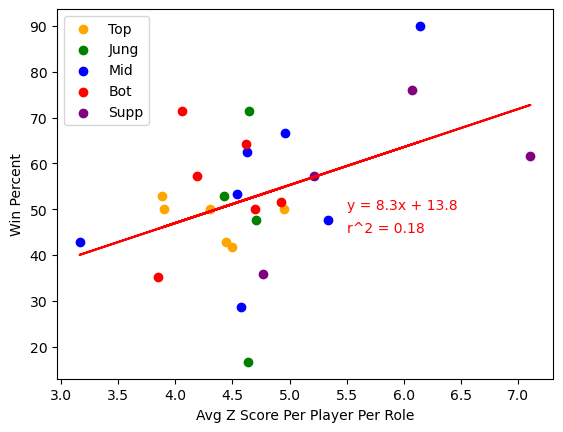

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = game_data['AvgToxicScore']
y = game_data['WinPercent']

(slope, intercept, r, p, stderr) = linregress(x, y)
fit = slope*x + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
rsquaredvalue = "r^2 = " + str(round(r**2, 2))
plt.scatter(df_top['AvgToxicScore'], df_top['WinPercent'], c = 'orange', label = 'Top')
plt.scatter(df_jung['AvgToxicScore'], df_jung['WinPercent'], c = 'green', label = 'Jung');
plt.scatter(df_mid['AvgToxicScore'], df_mid['WinPercent'], c = 'blue', label = 'Mid');
plt.scatter(df_bot['AvgToxicScore'], df_bot['WinPercent'], c = 'red', label = 'Bot');
plt.scatter(df_supp['AvgToxicScore'], df_supp['WinPercent'], c = 'purple', label = 'Supp');
plt.plot(x, fit, "r-")
plt.annotate(line_eq,(5.5, 50), fontsize = 10 ,color = 'red')
plt.annotate(rsquaredvalue,(5.5, 45), fontsize = 10, color = 'red')
plt.xlabel('Avg Z Score Per Player Per Role')
plt.ylabel('Win Percent')
plt.legend(loc='upper left')
plt.show()